In [1]:
import os
import re
import glob
import itertools
import numpy as np
import pandas as pd
import text_preprocessing as tp
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aakash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Identify narcissism in text 

The goal of this project is to identify multiple dimensions or single prominent dimension of narcissism, thereby defining a semantic space for narcissism using these dimension/s. This project aims to create a semantic space and map a random document of natural language based text in this space to quantify narcissism embedded in an unseen text. Such a tool, that could quantify narcissism in natural language, could help identify interactions that could potentially be unhealthy in long run. 

Here are the steps that we follow:

- Load dataset of individual experiences of narcissism.
- Preprocess texts in the dataset by filtering ununsual words, stop words, punctuations, and tokenization
- Compute tfidf values for words in each of the preprocessed text
- Apply TruncatedSVD on tfidf values to transform into two dimensional space
- Project a random document on transformed 2D space
- Compute cosine similarity between random document and first principal component to quantify degree of association of a document with the narcissism's first principal component

### Step 1: Load the dataset of individual experiences of narcissism

The dataset, used to extract important dimensions of narcissism, is the voice of the individuals that exhibited some form of relationship with a narcissist. There is a higher chance of understanding the dimensions of narcissism through these people's voices as they could tell the real behavior of an individual who exhibits multiple personality characteristics that vary depending on the relationship you are exhibiting with such narcissistic individuals. 

The first principal component is the representation of an important dimension or dimensions of narcissism that contribute to their behavior. If there are multiple dimensions, it will be hard to capture these dimensions as these personality characteristics based dimensions might co-occur and hence correlate among individuals. So, identifying orthogonal dimensions could be a difficult, if not tedious, task. One important point to note here is that data points lying on the axes of each of the orthogonal dimensions represents that these data points has no association with other dimensions (zero coordinate values). 

If a text projected onto this dimension has a large projected length, then we can say that the words in the text are associated with or belong to the first prinicipal component extracted from texts describing experience with narcissism. We can say that this text has high degree of narcissism.

We will not be able to tag a narcissist from the voice of the individuals who were in some form of relationship with a narcissist because the voice is the experience with a narcissist, so a perception of a narcissist from the experiencer. We will be able to tag the experience of a relationship with a narcissist. Can the perception of a narcissist be used to tag a narcissist? We could tag a narcissist from the perception of the individual who is interacting with the narcissist. But, we are not sure if we will be able to tag a narcissist in general, without getting a lot of data that help identifies subtle cues of narcissism that are only evident to the individuals who have prolong contact with narcissists. So, the application we are trying to build is going to help the individuals who are in some form of relationship with a narcissist. 

If a text represents thoughts of or about a narcissist, that could create perceptions among perceivers. Perceptions about narccissism in the form of experiences with narcissists have been captured in the first principal component. So if association between text that creates/represents perceptions about a narcissist and the principal component that represents the experience of individuals with narcissists then the text captures perception of/about narcissism. This association can be used as an indicator of a relationship between text and narcissism.

In [2]:
initial_folder_path = os.getcwd()
folder_path = 'narcissism\\data'
text_files = []

os.chdir(folder_path)
for file in glob.glob("*.txt"):
    text_files.append(file)
os.chdir(initial_folder_path)

folder_path = 'narcissism\\data'
os.chdir(folder_path)
narc_experience_texts = []
for file in text_files:
    with open(file, encoding="utf8") as f:
        narc_experience_texts.append(' '.join(f.read().splitlines()))
os.chdir(initial_folder_path)

### Step 2: Preprocess texts in the dataset

In [3]:
preprocess_obj = tp.PreprocessDocs() # default argument values are 'lemmatization' = 'yes', 'stemming' = no, 'stopwords_remove' = 'yes'
doc_min_size = 5 # see text_preprocessing.py for description of variables
clean_docs = preprocess_obj.docs_preprocess(narc_experience_texts, doc_min_size)

print("Number of cleaned paragraphs in the pdf: ", len(clean_docs))

Number of cleaned paragraphs in the pdf:  11


### Step 3: Compute tfidf values for words in each of the preprocessed text

TFIDF penalizes words that are common across experiences. We would like to have such words not penalized heavily as they represent experiences common across individuals in some form of relationship with narcissists. 

Using a TFIDF measure that penalizes words common across documents will extract words that are more unique to the individual experiences than experiences common among all individuals. We do not want low tfidf values for the words that are common across individual experiences.

In [4]:
# Use tfidf CountVectorizer provided in scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
corpus = [' '.join(doc) for doc in clean_docs]

X = vectorizer.fit_transform(corpus)
corpus_wlist = vectorizer.vocabulary_.keys()

### Step 4: Apply TruncatedSVD on tfidf values to transform into two dimensional space

In order to identify dimensions of narcissism, comprising of words that appear in narcissistic experiences, we use Principal Component Analysis.

Principal Component Analysis is a dimension reduction technique that identifies direction of maximum variance among sample data. In our case, we find the direction of maximum variance in tfidf values. One good thing about PCA is that it does not assume any prior distribution associated with the sample data. Hence, it is a non parametric method for dimension reduction. In our sample data of tfidf values of words in narcissistic texts, we do not know the distribution. Hence, PCA fits well in our situation.

We use TruncatedSVD instead of PCA as we have very sparse data, a very few words are common across narcissistic texts resulting in a lot of zero tfidf values in each text. In truncatedSVD, we do not center data as most of the values are zero, the mean will be close to zero.

In [5]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=2, random_state=42)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns=['principalcomponent1', 'principalcomponent2'])
#principalDf['label'] = corpus_wlist
pc1_df = pd.DataFrame(principalDf['principalcomponent1'].sort_values(ascending=False).iloc[:30])
pc2_df = pd.DataFrame(principalDf['principalcomponent2'].sort_values(ascending=False).iloc[:30])
pc12_df = pd.concat([pc1_df, pc2_df], axis = 1, join = 'outer', ignore_index=False, sort=False)
pc12_df

,principalcomponent1,principalcomponent2
0,2.331668,0.188076
1,7.493959,-2.491064
2,3.582299,-1.899610
3,2.507246,-2.172572
4,2.402482,-0.359811
5,10.900462,-7.735103
6,10.925902,10.603316
7,4.505871,0.545022
8,2.351395,-0.644787
9,1.265904,0.071845


In [6]:
df_pc = pd.DataFrame(vectorizer.vocabulary_.items(), columns=['vocab', 'order'])
df_pc.sort_values(by=['order'], inplace=True)
df_pc['pc1'] = pca.components_[0]
df_pc['pc2'] = pca.components_[1]
df_pc = df_pc.reset_index(drop=True)
del df_pc['order']
df_pc

,vocab,pc1,pc2
0,absolute,0.030695,-0.041106
1,absolutely,0.025986,-0.016974
2,absorb,0.006765,-0.001912
3,abuse,0.041277,-0.033428
4,abuser,0.013331,-0.007090
...,...,...,...
469,wonder,0.010087,-0.010095
470,word,0.030766,0.056349
471,worth,0.010087,-0.010095
472,write,0.030695,-0.041106


<Figure size 1440x720 with 0 Axes>

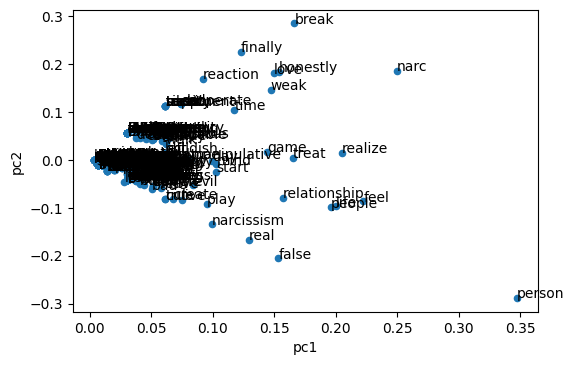

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.rcParams['figure.dpi'] = 100
df_pc.plot.scatter(x='pc1',y='pc2')

for i in range(df_pc.shape[0]):
    plt.text(x=df_pc.pc1[i], y=df_pc.pc2[i], s=df_pc.vocab[i])

plt.xlabel("pc1") #x label
plt.ylabel("pc2") #y label
plt.show()

### Step 5: Project a random document on transformed 2D space

In [8]:
new_document = narc_experience_texts[1]

# Preprocess new document
preprocessed_new_doc = preprocess_obj.docs_preprocess([new_document], doc_min_size)[0]

# Vectorize the new document
doc_vec = vectorizer.transform([' '.join(preprocessed_new_doc)])

# Project vectorized document onto principal components
pca.transform(doc_vec)

array([[ 7.49395875, -2.49106413]])

### Step 6: Quantify narcissistic experience in a document

In [9]:
# Compute projection of a document on first principal component
round(pca.transform(doc_vec)[0][0]/np.linalg.norm(pca.transform(doc_vec)), 3)

0.949

In [10]:
new_document1 = 'Right from things like playing loud music to closing the doors behind loudly. Not only these objective behaviours. But also the conversations were always turned around to his problems. Whenever it was about my interests, they were made fun of and ridiculed. Soon enough, I decided to have no contact with my flatmate and started having very few conversations, like once a week. When I confronted him about the way he converses, he immediately said this is not me and that he cannot have said any of that. Although, he did accept points around loud noice and late night sounds and kept them low. But the conversations according to me would have never improved and hence I kept my distance.'
# Preprocess new document
preprocessed_new_doc = preprocess_obj.docs_preprocess([new_document1], doc_min_size)[0]

# Vectorize the new document
doc_vec = vectorizer.transform([' '.join(preprocessed_new_doc)])

# Project vectorized document onto principal components
pca.transform(doc_vec)
round(pca.transform(doc_vec)[0][0]/np.linalg.norm(pca.transform(doc_vec)), 3)

0.805